In [1]:
import gc   # For manual garbage collection.
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

experiment = 'Exp1'

# Import and select data.
all_data = pd.read_csv('total_data.csv',
    usecols = ['gps.lat', 'gps.lon', 'altitudeRelative', 'Concentration', 'Experiment'],
)
all_data = all_data[all_data['Experiment'] == experiment]
all_data = all_data.drop(columns = ['Experiment'])

# Import and select metadata.
experiment_metadata = pd.read_csv('data_summary.csv',
    usecols = ['Experiment', 'Wind_Dir', 'WindSpeed', 'boat.lat', 'boat.lon']
)
experiment_metadata = experiment_metadata[experiment_metadata['Experiment'] == experiment]
wind_dir = experiment_metadata['Wind_Dir'].values[0]
wind_speed = experiment_metadata['WindSpeed'].values[0]

# Converting lat and lon to distances from boat in downwind and crosswind directions.
all_data['dist_lat'] = (all_data['gps.lat'] - experiment_metadata['boat.lat'].values[0]) * 111000
all_data['dist_lon'] = (all_data['gps.lon'] - experiment_metadata['boat.lon'].values[0]) * 111000
all_data['x'] = all_data['dist_lon'] * np.cos(270 - wind_dir) + all_data['dist_lat'] * np.sin(270 - wind_dir)
all_data['y'] = all_data['dist_lon'] * np.cos(360 - wind_dir) + all_data['dist_lat'] * np.sin(360 - wind_dir)
all_data['z'] = all_data['altitudeRelative']

# Modify concentrations.
all_data['Concentration'] = all_data['Concentration'] * 0.01 ** 3

# Release unused memory.
all_data = all_data.drop(columns = ['altitudeRelative', 'dist_lat', 'dist_lon', 'gps.lat', 'gps.lon'])
del(experiment)
del(experiment_metadata)
del(wind_dir)
gc.collect()

# Split into training and test data.
training_data, testing_data = train_test_split(all_data, test_size=0.2)

In [11]:
print(np.std(training_data['Concentration']))

0.0007342130860521879


In [27]:
# Inference and model parameters.
H = 0

prior_params = {
    "k_a" : 0.33,
    "k_b" : 0.86,
    "k_Q" : 1.1e-3,
    "theta_a" : 1,
    "theta_b" : 1,
    "theta_Q" : 1e-3,
    "sigma_0" : 1e-4,
    "s" : 1e-4
}
prior_params = pd.Series(prior_params)

params_init = np.array([prior_params.k_a,prior_params.k_b,prior_params.k_Q,prior_params.sigma_0])

# Function for calculating the conditional probability for parameters a, b or Q.
def log_prob_params(params, prior_params, log_lhood):
    part_1 = (prior_params.k_a - 1)*np.log(params[0]) + (prior_params.k_b - 1)*np.log(params[1]) + (prior_params.k_Q - 1)*np.log(params[2])
    part_2 = -params[0]/prior_params.theta_a - params[1]/prior_params.theta_b - params[2]/prior_params.theta_Q
    part_3 = -(params[3]-prior_params.sigma_0)**2/(2*prior_params.s**2)
    return  part_1 + part_2 + part_3 + log_lhood


# MCMC Sampler for a, b or Q.
def sample_params(params, prior_params, ss, precalc2, N_data):

    # Set current and proposed values for a, b or Q.
    current_params = params
    proposed_params = np.random.multivariate_normal(mean = current_params, cov = ss)

    # Calculating the conditional probability of current and proposed a,b or Q.
    log_l_curr_params = -sum(precalc2)/(2*current_params[3]) - N_data*np.log(np.sqrt(2*np.pi)*current_params[3])
    log_l_prop_params = -sum(precalc2)/(2*proposed_params[3]) - N_data*np.log(np.sqrt(2*np.pi)*proposed_params[3])

    log_p_prop_params = log_prob_params(proposed_params, prior_params, log_l_prop_params)
    log_p_curr_params = log_prob_params(current_params, prior_params, log_l_prop_params)

    # Acceptance criteria.
    if np.random.uniform(low = 0, high = 1) < np.exp(log_p_prop_params - log_p_curr_params):
        return proposed_params, 1
    else:
        return current_params, 0


# Full MCMC sampler.
def sample_process(N_samples, ss, u, H, data, params_init, prior_params):

    # Intialisation. Pre-allocate memory space for the data where relevant.
    params_means = np.empty((N_samples, len(params_init)))    # rows = N_samples, cols = len(params_init).
    params_means[:] = np.NaN
    params_samples = params_means.copy()
    params = params_init
    count = 0
    negysqr = -data['y']**2
    piu = np.pi * u
    zdownsqr = -(data['z'] - H)**2
    zupsqr = -(data['z'] + H)**2
    N_data = data['x'].size

    tot_accepted = 0
    for j in range(N_samples):

        count = count + 1
        if (count % 1000 == 0):
            print('Running sample ' + str(count) + '...')    # Print progress every 1000th sample.

        precalc1 = np.array(2 * params[0] * data['x']**params[1])
        precalc2 = (params[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data['Concentration'])**2
                
        params, accepted = sample_params(params,prior_params,ss,precalc2,N_data)
        tot_accepted += accepted
        params_samples[j] = params.T
        params_means[j] = np.mean(params_samples[:count][:], axis = 0)

    print('Sampling complete.')
    print('Acceptance rate: ', tot_accepted/N_samples)
    return params_samples, params_means


# Run sampling.
np.random.seed(117)
params_samples, params_means = sample_process(N_samples = 100000, ss = np.diag([0.001, 0.001, 1e-6,1e-6]), u = wind_speed, H = H, data = training_data,
                                        params_init = params_init, prior_params = prior_params)

C:\Users\samue\AppData\Local\Temp/ipykernel_916/2115650114.py:35: RuntimeWarning: invalid value encountered in log
  log_l_prop_params = -sum(precalc2)/(2*proposed_params[3]) - N_data*np.log(np.sqrt(2*np.pi)*proposed_params[3])
C:\Users\samue\AppData\Local\Temp/ipykernel_916/2115650114.py:20: RuntimeWarning: invalid value encountered in log
  part_1 = (prior_params.k_a - 1)*np.log(params[0]) + (prior_params.k_b - 1)*np.log(params[1]) + (prior_params.k_Q - 1)*np.log(params[2])


Running sample 1000...
Running sample 2000...
Running sample 3000...
Running sample 4000...
Running sample 5000...
Running sample 6000...
Running sample 7000...
Running sample 8000...
Running sample 9000...
Running sample 10000...
Running sample 11000...
Running sample 12000...
Running sample 13000...
Running sample 14000...
Running sample 15000...
Running sample 16000...
Running sample 17000...
Running sample 18000...
Running sample 19000...
Running sample 20000...
Running sample 21000...
Running sample 22000...
Running sample 23000...
Running sample 24000...
Running sample 25000...
Running sample 26000...
Running sample 27000...
Running sample 28000...
Running sample 29000...
Running sample 30000...
Running sample 31000...
Running sample 32000...
Running sample 33000...
Running sample 34000...
Running sample 35000...
Running sample 36000...
Running sample 37000...
Running sample 38000...
Running sample 39000...
Running sample 40000...
Running sample 41000...
Running sample 42000...
R

In [28]:
# Utility function for traceplots.
def traceplots(x, xnames = None, title = None):

    N, d = x.shape
    fig = plt.figure()
    left, tracewidth, histwidth = 0.1, 0.65, 0.15
    bottom, rowheight = 0.1, 0.8/d
    spacing = 0.05

    for i in range(d):
        # Set the location of the trace and histogram viewports,
        # starting with the first dimension from the bottom of the canvas.
        rowbottom = bottom + i * rowheight
        rect_trace = (left, rowbottom, tracewidth, rowheight)
        rect_hist = (left + tracewidth, rowbottom, histwidth, rowheight)

        # First set of trace plot axes.
        if i == 0:
            ax_trace = fig.add_axes(rect_trace)
            ax_trace.plot(x[:,i])
            ax_trace.set_xlabel("Sample Count")
            ax_tr0 = ax_trace

        # Other sets of trace plot axes that share the first trace's x-axis.
        # Make tick labels invisible so they don't clutter up the plot.
        elif i > 0:
            ax_trace = fig.add_axes(rect_trace, sharex=ax_tr0)
            ax_trace.plot(x[:,i])
            plt.setp(ax_trace.get_xticklabels(), visible=False)

        # Title at the top.
        if i == d-1 and title is not None:
            plt.title(title)

        # Trace y-axis labels.
        if xnames is not None:
            ax_trace.set_ylabel(xnames[i])

        # Trace histograms at the right.
        ax_hist = fig.add_axes(rect_hist, sharey=ax_trace)
        ax_hist.hist(x[:,i], orientation='horizontal', bins=50)
        plt.setp(ax_hist.get_xticklabels(), visible=False)
        plt.setp(ax_hist.get_yticklabels(), visible=False)
        xlim = ax_hist.get_xlim()
        ax_hist.set_xlim([xlim[0], 1.1*xlim[1]])

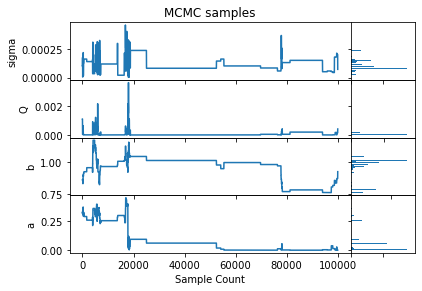

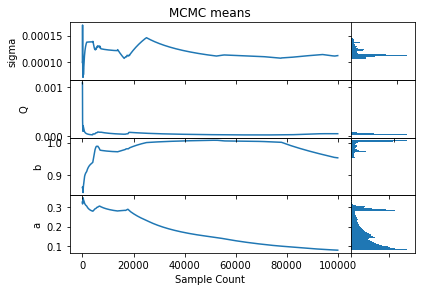

In [29]:
traceplots(params_samples, xnames = ['a', 'b', 'Q','sigma'], title = 'MCMC samples')
traceplots(params_means, xnames = ['a', 'b', 'Q','sigma'], title = 'MCMC means')

In [ ]:
# Gaussian Plume Model for concentration.
def C_func(x,y,z,u,a,b,Q,H):
    C = Q / (2*a*x**b*np.pi*u)*(np.exp(-(y**2)/(2*a*x**b)))*(np.exp(-(z-H)**2/(2*a*x**b))+np.exp(-(z+H)**2/(2*a*x**b)))
    return C

In [ ]:
# Plotting slices of the plume at set Z values using the mean values of the parameters.

abQ_mean = abQ_means[-1]
x = np.linspace(0.1, 200, 201)
y = np.linspace(-20, 20, 201)
#z = np.linspace(0, 400, 201)
X,Y = np.meshgrid(x, y)
Z = 10
C = C_func(X, Y, Z, wind_speed, abQ_mean[0], abQ_mean[1], abQ_mean[2], H)
plt.pcolor(X, Y, C, shading = 'auto')
plt.colorbar()
plt.title('Plume concentration at z = ' + str(Z))
plt.xlabel('x')
plt.ylabel('y')
print('Inferred means: x = ', round(abQ_mean[0], 2), ', y = ', round(abQ_mean[1], 2), ', z = ', round(abQ_mean[2], 2), '.', sep = '')

del(x)
del(y)

In [ ]:
# Calculating the RMSE of this new model based on the data
def RMSE_func(abQ, u, H, data):

    # Gaussian Plume Model for concentration.

    negysqr = -data['y']**2
    piu = np.pi * u
    zdownsqr = -(data['z'] - H)**2
    zupsqr = -(data['z'] + H)**2
    precalc1 = np.array(2 * abQ[0] * data['x']**abQ[1])
    precalc2 = (abQ[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data['Concentration'])**2

    print(np.max(np.sqrt(precalc2)))

    RMSE = np.sqrt(sum(precalc2)/data.shape[0])
    print('RMSE = ' + str(RMSE))
    return RMSE


RMSE = RMSE_func(abQ_mean, wind_speed, H, testing_data)

data_range = np.max(testing_data['Concentration']) - np.min(testing_data['Concentration'])

print('Range = ' + str(data_range))

# # saving_samples = pd.DataFrame({'a':abQ_samples[:,0],'b':abQ_samples[:,1],'Q':abQ_samples[:,2]})
# saving_samples = pd.DataFrame(abQ_samples,columns=['a','b','Q'])
# saving_samples.to_csv('samples.csv')

In [ ]:
# Print the values of a, b and Q
def print_vals(abQ_samples):

    abQ_samples = np.array(abQ_samples)
    vals = ['a','b','Q']
    for i in range(abQ_samples.shape[1]):
        print(vals[i] + ' = ' + str(np.mean(abQ_samples[:,i])) + ' +/- ' + str(np.std(abQ_samples[:,i])))
        
print_vals(abQ_samples)